In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

Подгружаем эмбеддинги

In [2]:
if 'embeddings' not in globals() or embeddings is None:
    embeddings = None

    try:
        if os.path.exists('embeddings_bundle.pkl'):
            with open('embeddings_bundle.pkl', 'rb') as f:
                obj = pickle.load(f)
            if isinstance(obj, dict):
                embeddings = obj
    except Exception:
        embeddings = None

    if embeddings is None:
        files = {
            'resnet_train': 'embeddings_resnet_train.pkl',
            'resnet_test':  'embeddings_resnet_test.pkl',
            'simple_train': 'embeddings_simplecnn_train.pkl',
            'simple_test':  'embeddings_simplecnn_test.pkl',
        }
        if all(os.path.exists(p) for p in files.values()):
            try:
                with open(files['resnet_train'], 'rb') as f: dtr_r = pickle.load(f)
                with open(files['resnet_test'],  'rb') as f: dte_r = pickle.load(f)
                with open(files['simple_train'], 'rb') as f: dtr_s = pickle.load(f)
                with open(files['simple_test'],  'rb') as f: dte_s = pickle.load(f)

                Xtr_resnet = np.asarray(dtr_r['X'], dtype=np.float32)
                ytr_resnet = np.asarray(dtr_r['y'], dtype=np.int64)
                Xte_resnet = np.asarray(dte_r['X'], dtype=np.float32)
                yte_resnet = np.asarray(dte_r['y'], dtype=np.int64)

                Xtr_simple = np.asarray(dtr_s['X'], dtype=np.float32)
                ytr_simple = np.asarray(dtr_s['y'], dtype=np.int64)
                Xte_simple = np.asarray(dte_s['X'], dtype=np.float32)
                yte_simple = np.asarray(dte_s['y'], dtype=np.int64)

                embeddings = {
                    'resnet': (Xtr_resnet, ytr_resnet, Xte_resnet, yte_resnet),
                    'simplecnn': (Xtr_simple, ytr_simple, Xte_simple, yte_simple),
                }
            except Exception:
                embeddings = None

    if embeddings is None:
        print('Warning: embeddings are not available. Run 2_embeddings.ipynb to create pkl files or 3_generative_gmm.ipynb to save the bundle.')

Определяем функции для расчёта метрик (accuracy, precision, recall,f1), применения pca и скейлинга, создания моделей

In [3]:
def compute_metrics_full(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    return {
        'accuracy': float(acc),
        'f1_macro': float(f_macro),
        'precision_macro': float(p_macro),
        'recall_macro': float(r_macro),
    }


def fit_transform_pca_scaler(X_train, X_valid, pca_dim):
    Xtr_p, Xva_p = X_train, X_valid
    if pca_dim is not None:
        pca = PCA(n_components=pca_dim, random_state=42)
        Xtr_p = pca.fit_transform(X_train)
        Xva_p = pca.transform(X_valid)
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr_p)
    Xva_s = scaler.transform(Xva_p)
    return Xtr_s, Xva_s


def build_model(model_name):
    if model_name == 'CatBoost':
        return CatBoostClassifier(
            iterations=250, learning_rate=0.07, depth=6,
            loss_function='MultiClass', eval_metric='Accuracy',
            allow_writing_files=False, verbose=0, random_state=42
        )
    if model_name == 'RandomForest':
        return RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
    if model_name == 'GaussianNB':
        return GaussianNB()
    if model_name == 'EM_GMM':
        return 'EM_GMM'
    raise ValueError('Unknown model')


def train_predict(model, Xtr_s, ytr, Xva_s, model_name, n_classes):
    if model_name == 'EM_GMM':
        gmms = []
        for c in range(n_classes):
            Xc = Xtr_s[ytr == c]
            g = GaussianMixture(n_components=1, covariance_type='full', random_state=42, max_iter=100)
            g.fit(Xc)
            gmms.append(g)
        logps = np.column_stack([g.score_samples(Xva_s) for g in gmms])
        y_pred = logps.argmax(axis=1)
        return y_pred
    else:
        model.fit(Xtr_s, ytr)
        y_pred = model.predict(Xva_s)
        return y_pred

Подбираем размерности pca для моделей на разных эмбеддингах по f1 через кросс-валидациб

In [4]:
pca_grid = {
    'resnet':     [32, 64, 128],
    'simplecnn':  [16, 32, 64],
}
models = ['CatBoost', 'RandomForest', 'GaussianNB', 'EM_GMM']

def cv_select_pca_dim(X_train, y_train, emb_name, model_name, cv_splits=5):
    dims = pca_grid[emb_name]
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scores = []

    for d in dims:
        fold_scores = []
        for tr_idx, va_idx in skf.split(X_train, y_train):
            Xtr, Xva = X_train[tr_idx], X_train[va_idx]
            ytr, yva = y_train[tr_idx], y_train[va_idx]
            Xtr_s, Xva_s = fit_transform_pca_scaler(Xtr, Xva, pca_dim=d)
            mdl = build_model(model_name)
            y_pred = train_predict(mdl, Xtr_s, ytr, Xva_s, model_name, n_classes=len(np.unique(y_train)))
            m = compute_metrics_full(yva, y_pred)
            fold_scores.append(m['f1_macro'])
        mean = float(np.mean(fold_scores))
        scores.append((d, mean))

    best_dim, best_mean = max(scores, key=lambda x: x[1])
    return best_dim, scores

best_pca = {}
cv_results = {}

for emb_name, (Xtr, ytr, Xte, yte) in embeddings.items():
    for model_name in models:
        best_dim, all_scores = cv_select_pca_dim(Xtr, ytr, emb_name, model_name, cv_splits=5)
        best_pca[(model_name, emb_name)] = best_dim
        cv_results[(model_name, emb_name)] = all_scores

Сводим результаты cv в multiindex dataframe и строим сравнение f1 для разных размерностей pca

Мультииндексная таблица результатов:
                                F1_Score
Model        Embedding PCA_Dim          
CatBoost     resnet    32       0.975879
                       64       0.976072
                       128      0.974383
RandomForest resnet    32       0.974882
                       64       0.973810
                       128      0.973791
GaussianNB   resnet    32       0.968007
                       64       0.967563
                       128      0.964840
EM_GMM       resnet    32       0.974873
                       64       0.977663
                       128      0.980287
CatBoost     simplecnn 16       0.667598
                       32       0.694037
                       64       0.709359
RandomForest simplecnn 16       0.651640
                       32       0.677497
                       64       0.688430
GaussianNB   simplecnn 16       0.595439
                       32       0.619632


Лучшие результаты по каждой модели и эмбеддингу:
          

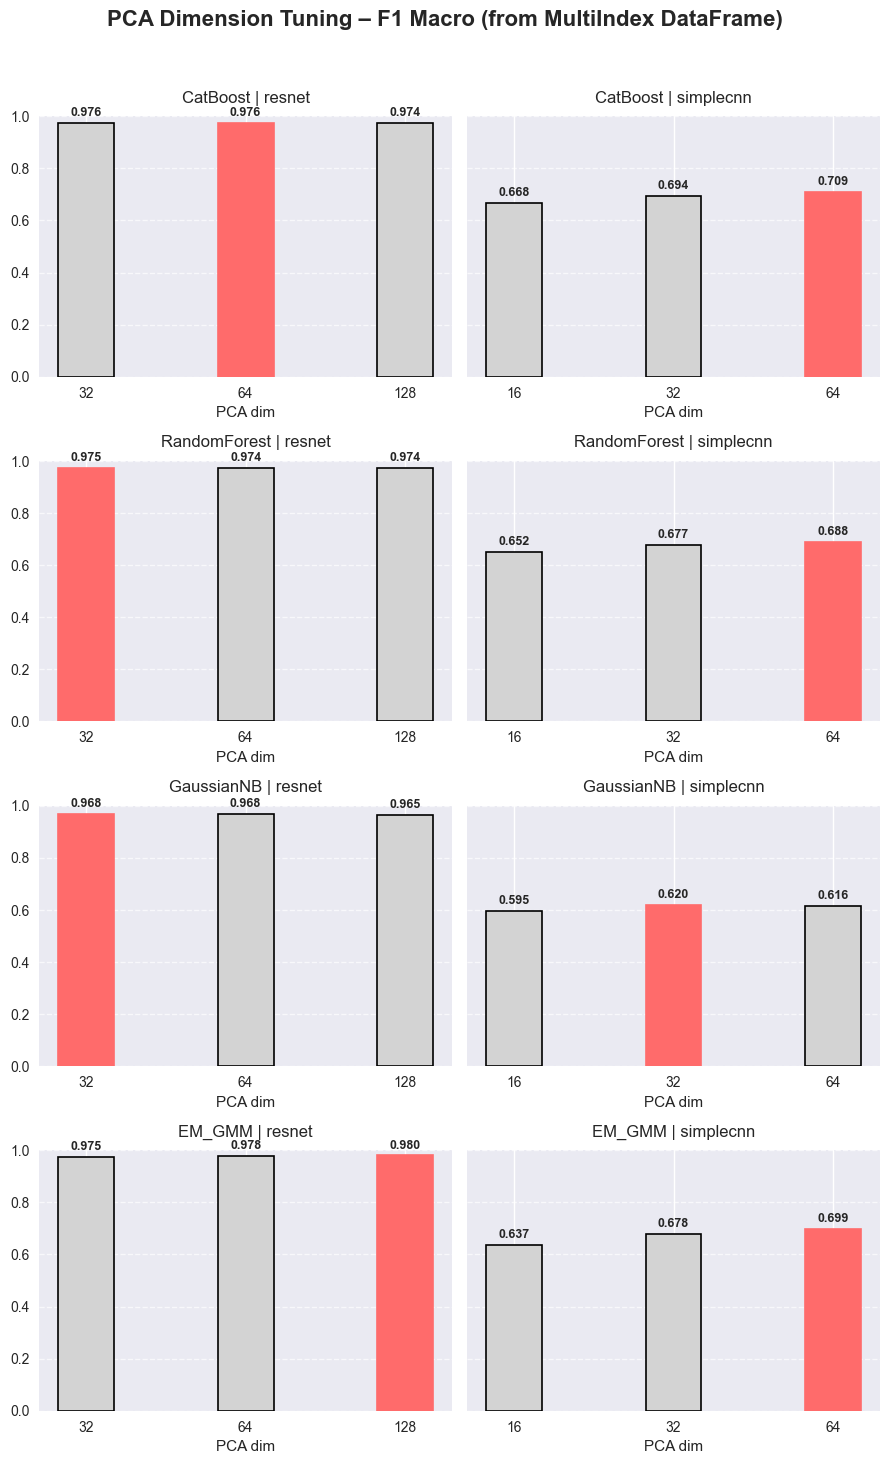

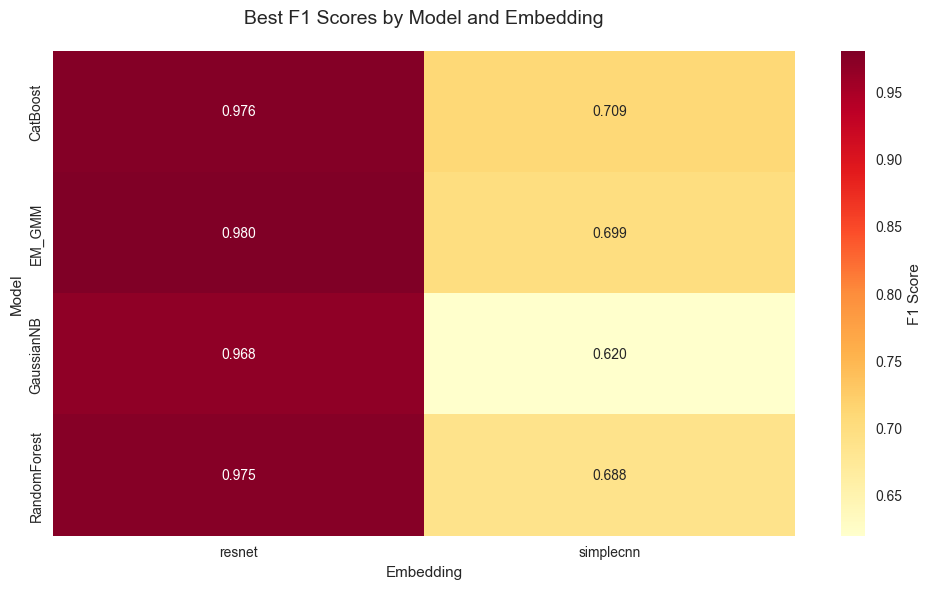

In [5]:
plt.style.use('seaborn-v0_8')

def create_multiindex_df(cv_results):
    data = []
    index_tuples = []
    
    for (model_name, emb_name), scores in cv_results.items():
        dims, means = zip(*sorted(scores))
        for dim, mean in zip(dims, means):
            data.append(mean)
            index_tuples.append((model_name, emb_name, dim))
    
    multi_index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=['Model', 'Embedding', 'PCA_Dim']
    )
    
    df = pd.DataFrame(data, index=multi_index, columns=['F1_Score'])
    return df

multiindex_df = create_multiindex_df(cv_results)

print("Мультииндексная таблица результатов:")
print(multiindex_df.head(20))
print("\n" + "="*50 + "\n")

print("Лучшие результаты по каждой модели и эмбеддингу:")
best_results = multiindex_df.groupby(level=['Model', 'Embedding']).max()
print(best_results)
print("\n" + "="*50 + "\n")

BAR_WIDTH = 0.35

models_idx = multiindex_df.index.get_level_values('Model').unique()
embeddings_idx = multiindex_df.index.get_level_values('Embedding').unique()

n_models = len(models_idx)
n_embs = len(embeddings_idx)

fig, axes = plt.subplots(
    n_models, n_embs,
    figsize=(4.5 * n_embs, 3.8 * n_models),
    squeeze=False,
    sharey=True
)

for i, model_name in enumerate(models_idx):
    for j, emb_name in enumerate(embeddings_idx):
        ax = axes[i, j]
        
        model_emb_data = multiindex_df.xs((model_name, emb_name), level=['Model', 'Embedding'])
        dims = model_emb_data.index.tolist()
        means = model_emb_data['F1_Score'].tolist()
        
        best_idx = int(np.argmax(means)) if len(means) else 0
        x_pos = np.arange(len(dims))

        bars = ax.bar(
            x_pos, means,
            width=BAR_WIDTH,
            color='lightgray',
            edgecolor='black',
            linewidth=1.2
        )
        if len(bars):
            bars[best_idx].set_color('#ff6b6b')

        ax.set_xlabel('PCA dim', fontsize=11)
        ax.set_title(f'{model_name} | {emb_name}', fontsize=12, pad=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(dims)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(0, 1.0)

        for bar, val in zip(bars, means):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.015,
                f'{val:.3f}',
                ha='center', va='bottom',
                fontsize=9, fontweight='bold'
            )
 

fig.suptitle('PCA Dimension Tuning – F1 Macro (from MultiIndex DataFrame)', 
             fontsize=16, fontweight='bold', y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

if not best_results.empty:
    plt.figure(figsize=(10, 6))
    
    heatmap_data = best_results['F1_Score'].unstack(level='Embedding')
    
    import seaborn as sns
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt='.3f', 
                cmap='YlOrRd', 
                cbar_kws={'label': 'F1 Score'})
    
    plt.title('Best F1 Scores by Model and Embedding', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

Обучаем модели на всём train с оптимальным кол-вом компонент pca и оцениваем на test, собираем сводную таблицу метрик и
визуализируем сравнение моделей по четырём метрикам

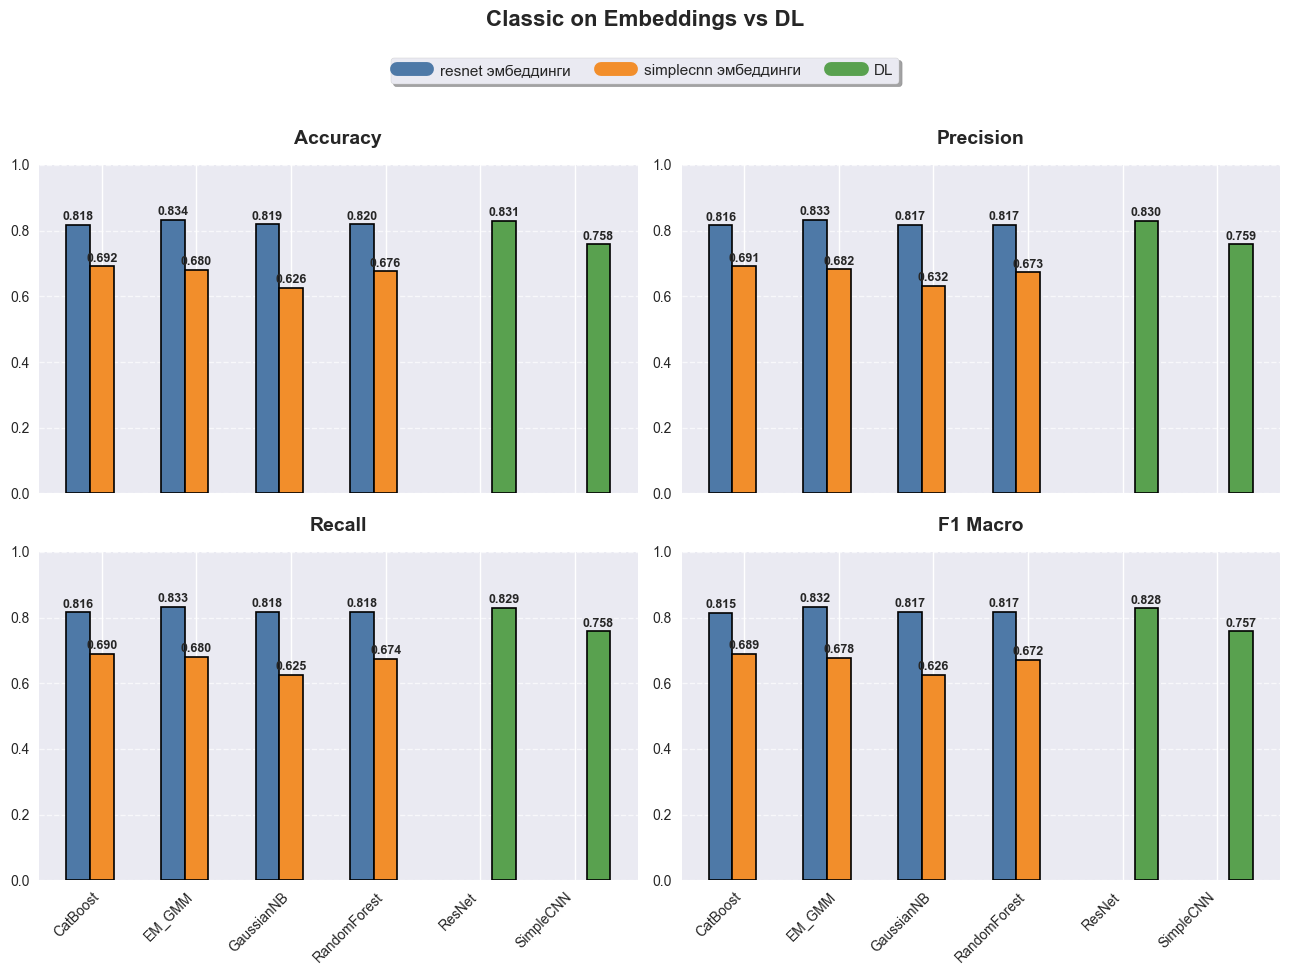

In [8]:
plt.style.use('seaborn-v0_8')

classic_results = []

dl_metrics = None
if os.path.exists('dl_baselines_metrics.json'):
    try:
        with open('dl_baselines_metrics.json', 'r') as f:
            dl_metrics = json.load(f)
    except Exception:
        dl_metrics = None

def final_train_test(model_name, emb_name, Xtr, ytr, Xte, yte, best_dim):
    Xtr_s, Xte_s = fit_transform_pca_scaler(Xtr, Xte, pca_dim=best_dim)
    mdl = build_model(model_name)
    y_pred = train_predict(mdl, Xtr_s, ytr, Xte_s, model_name, n_classes=len(np.unique(ytr)))
    m = compute_metrics_full(yte, y_pred)
    classic_results.append({
        'model': model_name,
        'emb': emb_name,
        'pca_dim': best_dim,
        **m,
    })

for emb_name, (Xtr, ytr, Xte, yte) in embeddings.items():
    for model_name in models:
        best_dim = best_pca[(model_name, emb_name)]
        final_train_test(model_name, emb_name, Xtr, ytr, Xte, yte, best_dim)

metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Macro']

rows = []
rows += classic_results
if dl_metrics is not None:
    for mdl_name, vals in dl_metrics.items():
        rows.append({
            'model': mdl_name,
            'emb': 'DL',
            'pca_dim': None,
            **vals,
        })

df_results = pd.DataFrame(rows)

fig, axes = plt.subplots(2, 2, figsize=(13, 10), sharex=True)
axes = axes.flatten()

series = ['resnet', 'simplecnn', 'DL']
colors = {'resnet': '#4e79a7', 'simplecnn': '#f28e2b', 'DL': '#59a14f'}

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]

    models_cls = sorted(df_results[df_results['emb'] != 'DL']['model'].unique().tolist())
    models_dl  = sorted(df_results[df_results['emb'] == 'DL']['model'].unique().tolist()) if 'emb' in df_results else []

    union_models = models_cls + [m for m in models_dl if m not in models_cls]
    x = np.arange(len(union_models))

    width = 0.25
    offsets = {
        'resnet': -width,
        'simplecnn': 0.0,
        'DL': width,
    }

    for s in series:
        if s == 'DL':
            sub = df_results[df_results['emb'] == 'DL'][['model', metric]].set_index('model') if 'emb' in df_results else pd.DataFrame()
            vals = [sub.loc[m, metric] if (not sub.empty and m in sub.index) else np.nan for m in union_models]
        else:
            sub = (df_results[df_results['emb'] == s]
                   .pivot(index='model', columns='emb', values=metric))
            vals = [sub.loc[m, s] if (not sub.empty and m in sub.index and s in sub.columns) else np.nan for m in union_models]

        vals = np.array(vals, dtype=float)
        mask = ~np.isnan(vals)
        bars = ax.bar(x[mask] + offsets[s], vals[mask], width=width,
                      color=colors[s], edgecolor='black', linewidth=1.2,
                      label=s if idx == 0 else None)
        for bar, val in zip(bars, vals[mask]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_title(name, fontsize=14, pad=15, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(union_models, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

handles = [plt.Line2D([0],[0], color=colors[k], lw=10) for k in series]
labels = ['resnet эмбеддинги', 'simplecnn эмбеддинги', 'DL']
fig.legend(handles, labels, title='', loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3,
           fontsize=11, title_fontsize=12, frameon=True, fancybox=True, shadow=True)

plt.suptitle('Classic on Embeddings vs DL', fontsize=16, weight='bold', y=0.99)
plt.tight_layout(rect=[0, 0.02, 1, 0.92])
plt.show()

На эмбеддингах resnet классические модели (особенно em/gmm) достигают лучших метрик, немного опережая просто resnet18. На эмбеддингах simplecnn классические модели заметно уступают, тогда как сама simplecnn даёт метрики от 0.74 до 0.76 в среднем, то есть для менее информативных эмбеддингов обучение напрямую на изображениях выигрывает

Для классических моделей считаем auc в постановке one-vs-rest (так как изначально roc-auc строится для бинарной классификации, а у нас 10 классов), усредняя по классам результаты. Для catboost'а, леса и наивного байеса используем predict_proba на тесте (после pca и стандартизации). Для em/gmm обучаем по одной гауссиане на класс, считаем лог‑правдоподобия log p(x|y=c) и преобразуем их в квазипостериоры через softmax по классам. Выводим таблицу auc для сравнения моделей и типов эмбеддингов

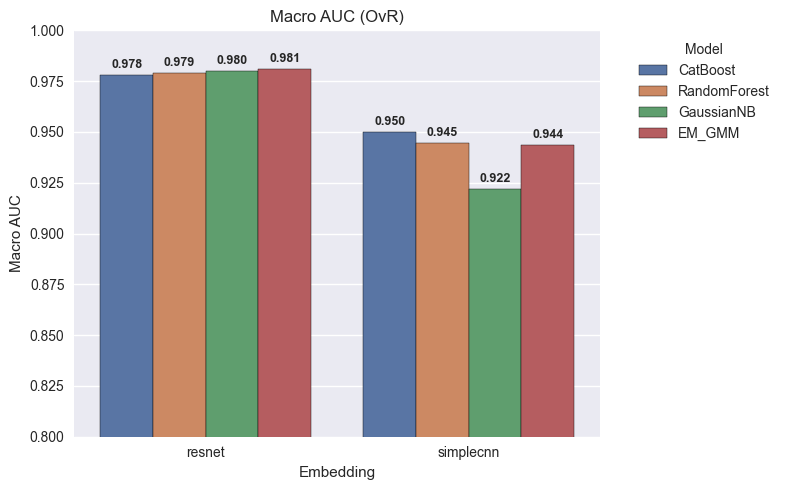

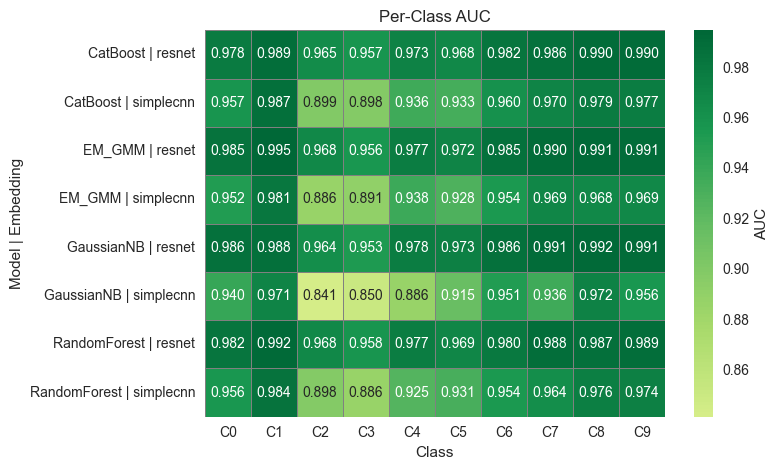

In [9]:
def softmax_rows(logits):
    m = logits.max(axis=1, keepdims=True)
    e = np.exp(logits - m)
    return e / e.sum(axis=1, keepdims=True)


def get_model_proba(model_name, Xtr, ytr, Xte, yte, pca_dim, num_classes):
    Xtr_s, Xte_s = fit_transform_pca_scaler(Xtr, Xte, pca_dim=pca_dim)

    if model_name == 'CatBoost':
        m = CatBoostClassifier(
            iterations=300, learning_rate=0.05, depth=6,
            loss_function='MultiClass', eval_metric='Accuracy',
            allow_writing_files=False, verbose=0, random_state=42
        )
        m.fit(Xtr_s, ytr)
        proba = m.predict_proba(Xte_s)

    elif model_name == 'RandomForest':
        m = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
        m.fit(Xtr_s, ytr)
        proba = m.predict_proba(Xte_s)

    elif model_name == 'GaussianNB':
        m = GaussianNB()
        m.fit(Xtr_s, ytr)
        proba = m.predict_proba(Xte_s)

    elif model_name == 'EM_GMM':
        gmms = []
        for c in range(num_classes):
            g = GaussianMixture(n_components=1, covariance_type='full', random_state=42, max_iter=100)
            g.fit(Xtr_s[ytr == c])
            gmms.append(g)
        logps = np.column_stack([g.score_samples(Xte_s) for g in gmms])
        proba = softmax_rows(logps)

    else:
        raise ValueError('Unknown model name')
    return proba


def compute_roc_auc_all_with_best_pca(embeddings_dict, best_pca_dict, num_classes):
    rows_macro = []
    perclass_data = []
    models_local = ['CatBoost', 'RandomForest', 'GaussianNB', 'EM_GMM']

    for emb_name, (Xtr, ytr, Xte, yte) in embeddings_dict.items():
        y_true_ovr = label_binarize(yte, classes=np.arange(num_classes))
        
        for model_name in models_local:
            pca_dim = best_pca_dict.get((model_name, emb_name), None)
            proba = get_model_proba(model_name, Xtr, ytr, Xte, yte, pca_dim, num_classes)
            
            auc_macro = roc_auc_score(y_true_ovr, proba, average='macro', multi_class='ovr')
            rows_macro.append({
                'model': model_name,
                'emb': emb_name,
                'pca_dim': pca_dim,
                'auc_macro_ovr': auc_macro
            })
            
            auc_per_class = [
                roc_auc_score(y_true_ovr[:, c], proba[:, c])
                for c in range(num_classes)
            ]
            for c, auc_c in enumerate(auc_per_class):
                perclass_data.append({
                    'model': model_name,
                    'emb': emb_name,
                    'class': f'C{c}',
                    'auc': auc_c
                })

    df_macro = pd.DataFrame(rows_macro)
    df_perclass = pd.DataFrame(perclass_data)

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df_macro,
        x='emb', y='auc_macro_ovr', hue='model',
        palette='deep', edgecolor='black'
    )
    plt.title('Macro AUC (OvR)')
    plt.xlabel('Embedding')
    plt.ylabel('Macro AUC')
    plt.ylim(0.8, 1)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        if height >= 0.8:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.002,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold'
            )
    plt.tight_layout()
    plt.show()

    df_perclass['model_emb'] = df_perclass['model'] + ' | ' + df_perclass['emb']
    pivot_perclass = df_perclass.pivot(index='model_emb', columns='class', values='auc')

    plt.figure(figsize=(max(8, num_classes * 0.7), len(pivot_perclass) * 0.6))
    sns.heatmap(
        pivot_perclass,
        annot=True, fmt='.3f', cmap='RdYlGn',
        center=0.8, cbar_kws={'label': 'AUC'},
        linewidths=0.5, linecolor='gray'
    )
    plt.title('Per-Class AUC')
    plt.xlabel('Class')
    plt.ylabel('Model | Embedding')
    plt.tight_layout()
    plt.show()

    return df_macro, df_perclass

df_auc, perclass_auc = compute_roc_auc_all_with_best_pca(embeddings, best_pca, num_classes=len(np.unique(list(embeddings.values())[0][1])))

На эмбеддингах resnet классические модели показывают высокие значения auc (около 0.98). То есть модельные оценки уверенно упорядочивают правильный класс выше остальных. На эмбеддингах simplecnn auc ниже, что указывает на менее выразительные признаки: упорядочивание по классам получается хуже, чем на эмбеддингах resnet. На resnet‑эмбеддингах разброс между классическими моделями минимален (catboost, randofForest,gaussiannb, gmm все около 0.98). Классификатор на gmm не уступает бустингу и лесу, что согласуется с тем, что классы в пространстве эмбеддингов resnet формируют гауссианы, которые удобно понимать gmm

В целом, если ориентироваться на auc, эмбеддинги resnet существенно лучше simplecnn; выбор конкретной классической модели на resnet играет меньшую роль, чем выбор пространства признаков

Строим roc‑кривые для каждой модели и каждого типа эмбеддингов, показываем кривые для каждого класса и усредняем результаты по классам, чтобы было легче визуально оценить качество

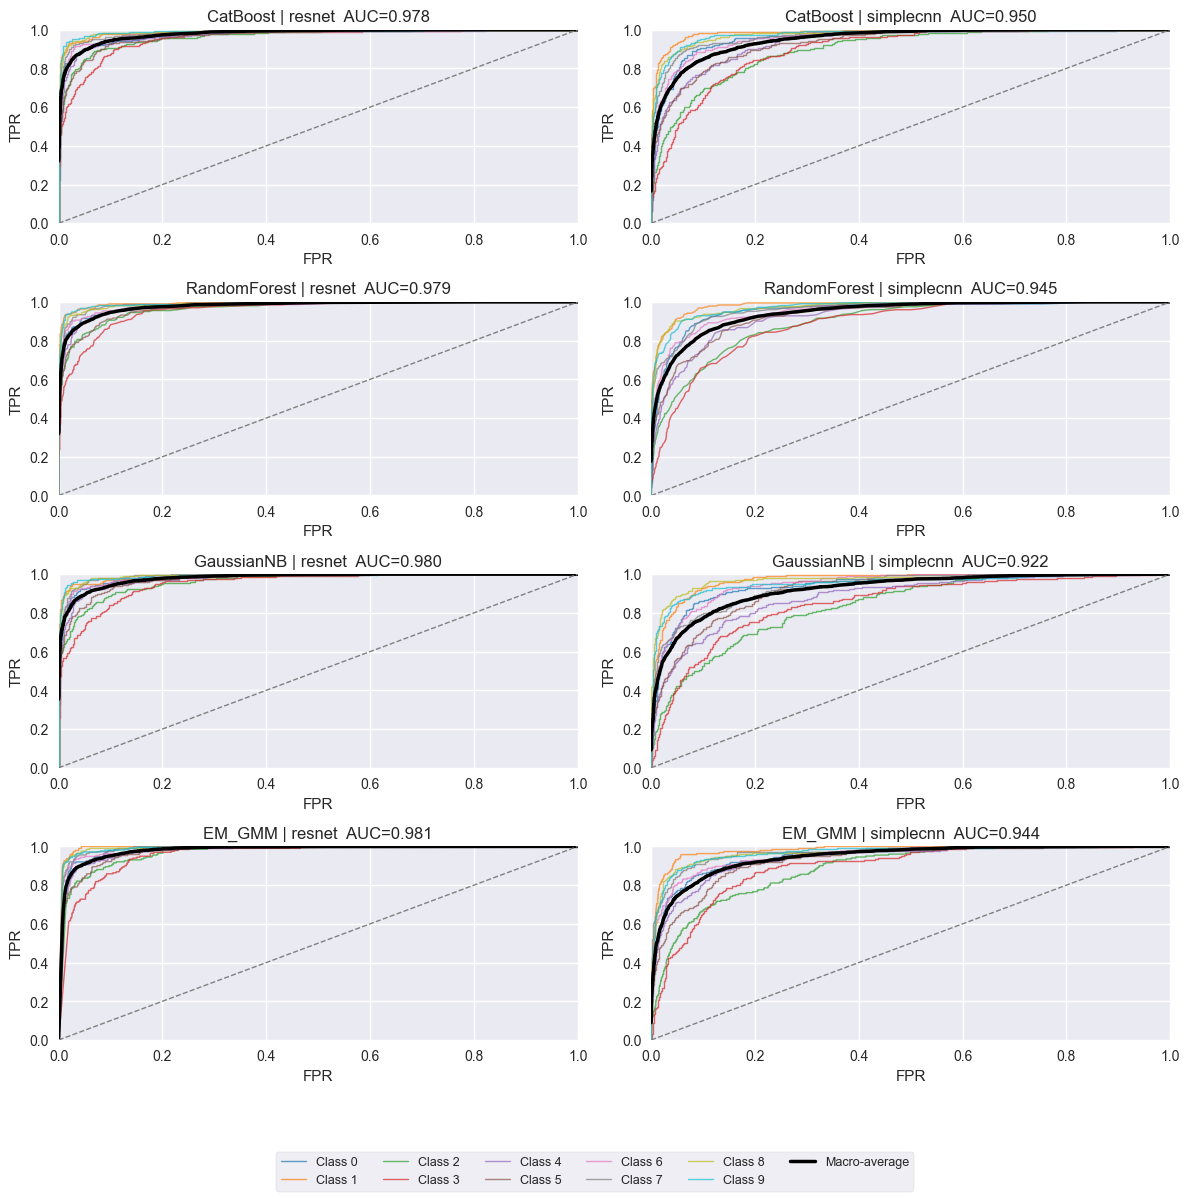

In [10]:
models_local = ['CatBoost', 'RandomForest', 'GaussianNB', 'EM_GMM']
emb_order = ['resnet', 'simplecnn']
num_classes = len(np.unique(list(embeddings.values())[0][1]))
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

fig, axes = plt.subplots(len(models_local), len(emb_order), figsize=(12, 12), squeeze=False)
legend_handles = None
legend_labels = None
for i, model_name in enumerate(models_local):
    for j, emb_name in enumerate(emb_order):
        Xtr, ytr, Xte, yte = embeddings[emb_name]
        pca_dim = best_pca.get((model_name, emb_name), None)
        proba = get_model_proba(model_name, Xtr, ytr, Xte, yte, pca_dim, num_classes)
        y_true_ovr = label_binarize(yte, classes=np.arange(num_classes))
        ax = axes[i, j]
        fprs, tprs = [], []
        local_handles = []
        for c in range(num_classes):
            fpr, tpr, _ = roc_curve(y_true_ovr[:, c], proba[:, c])
            fprs.append(fpr)
            tprs.append(tpr)
            line, = ax.plot(fpr, tpr, lw=1, alpha=0.7, color=colors[c])
            if legend_handles is None:
                local_handles.append(line)
        all_fpr = np.unique(np.concatenate(fprs))
        mean_tpr = np.zeros_like(all_fpr)
        for c in range(num_classes):
            mean_tpr += np.interp(all_fpr, fprs[c], tprs[c])
        mean_tpr /= num_classes
        macro_line, = ax.plot(all_fpr, mean_tpr, color='black', lw=2.5)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
        auc_macro = roc_auc_score(y_true_ovr, proba, average='macro', multi_class='ovr')
        ax.set_title(f'{model_name} | {emb_name}  AUC={auc_macro:.3f}')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        if legend_handles is None:
            legend_handles = local_handles + [macro_line]
            legend_labels = [f'Class {c}' for c in range(num_classes)] + ['Macro-average']

plt.tight_layout(rect=[0, 0.08, 1, 1])
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=min(6, len(legend_labels)), frameon=True, fontsize=9)
plt.show()